## WIDS Datathon 2022 on Climate Change
WiDS Datathon participants will analyze differences in building energy efficiency, creating models to predict building energy consumption. Participants will use a dataset consisting of variables that describe building characteristics and climate and weather variables for the regions in which the buildings are located. Accurate predictions of energy consumption can help policymakers target retrofitting efforts to maximize emissions reductions.

To know more about the data use this link https://www.kaggle.com/c/widsdatathon2022/data

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
pd.set_option('max_columns', 200)
%matplotlib inline
# from pandas_profiling import ProfileReport
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#plt.style.use('ggplot')

In [2]:
# bring it the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA and Data Pre-processing on the Training Dataset

In [3]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [4]:
train.shape

(75757, 64)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [6]:
# check for missing data
train.isnull().sum() # all the missing values is not visible here but from the info we can see 6 columns with missing values

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
id                               0
Length: 64, dtype: int64

From above you can see that the training dataset contains `75757` rows and `64` columns. From the look of things, this dataset is not tidy. Why do we need to tidy our data? Because Tidy datasets provide a standardized way to link the structure of a dataset (its physical layout) with its semantics (its meaning).
From the data features like january_min_temp,january_avg_temp... and the rest of it needs to be tidied. What does tidying our data involve? It involves the rows and columns, tidying a dataset depends on how the rows, columns and tables are matched up for observations, variables and types.

In tidy data:
1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table

We are going to implement this and to do this we will use a pandas function called `melt`. Read more about melt fuction here
https://pandas.pydata.org/docs/reference/api/pandas.melt.html
For Tidy Data, read more about it here https://vita.had.co.nz/papers/tidy-data.pdf. As a python user you can take from Chapter 1 to 4 but as a R user you can read all because this article codes is written in R

In [7]:
# let's melt our data
df_train = pd.melt(train, 
            id_vars = ['Year_Factor','State_Factor','building_class','facility_type', 'floor_area', 'year_built','energy_star_rating','ELEVATION',
                       'cooling_degree_days','heating_degree_days','precipitation_inches','snowfall_inches', 'snowdepth_inches','avg_temp',
                      'days_below_30F','days_below_20F','days_below_10F','days_below_0F',
                       'days_above_80F','days_above_90F','days_above_100F','days_above_110F','direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog',
                      'site_eui','id'])

From above the features i put in `id_vars` are those features i do not want to melt for now so to speak.

Note:
I melted those features with the name of the month prefix

In [8]:
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,variable,value
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,january_min_temp,36.0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,january_min_temp,36.0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,january_min_temp,36.0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,january_min_temp,36.0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,january_min_temp,36.0


In [10]:
# checking for the rows and column of the dataset
df_train.shape[0], df_train.shape[1]

(2727252, 30)

Now we have two new features that is the `variable` and `value`.We have to separate the variable columns into `months` (January and the rest) then `unit` (min_temp,max_temp). There are more tiying to be done, but i will stop here for now

In [11]:
# we will use split to separate the variable column
variable_split = df_train['variable'].str.split('_', n =1)

In [12]:
variable_split[0]

['january', 'min_temp']

In [13]:
variable_split[0][1] 

'min_temp'

In [14]:
# assign trhe splitted column to Months and Unit_Status
df_train['Months'] = variable_split.str.get(0)
df_train['Unit_Status'] = variable_split.str.get(1)

In [15]:
# Our data
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,variable,value,Months,Unit_Status
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,january_min_temp,36.0,january,min_temp
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,january_min_temp,36.0,january,min_temp
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,january_min_temp,36.0,january,min_temp
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,january_min_temp,36.0,january,min_temp
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,january_min_temp,36.0,january,min_temp


In [16]:
# rename the values column to Unit_value
df_train.rename(columns = {'value':'Unit_value'},inplace = True)

In [17]:
# we will drop the variable column because we have already splitted it into Months and Unit_Status
df_train.drop(['variable'], axis = 1, inplace = True)

In [18]:
df_train.shape

(2727252, 31)

Now after the melting we have `2727252` rows and `31` columns. Now let's encode the categorical values. I will use the map function

In [19]:
# df_train['State_Factor'].value_counts()

In [20]:
# we will use map to encode State_Factor which is a categorical feature
df_train['State_Factor'] = df_train['State_Factor'].map({'State_6':1,'State_11':2,'State_1':3,'State_2':4,'State_8':5,
                                                        'State_8':6,'State_10':7})

In [21]:
# df_train['building_class'].value_counts()

In [22]:
# we will use map to encode building_class which is a categorical feature
df_train['building_class'] = df_train['building_class'].map({'Residential':1, 'Commercial':2})

In [23]:
df_train['Months'].value_counts()

january      227271
february     227271
march        227271
april        227271
may          227271
june         227271
july         227271
august       227271
september    227271
october      227271
november     227271
december     227271
Name: Months, dtype: int64

In [24]:
# we will use map to encode Months which is a categorical feature
df_train['Months'] = df_train['Months'].map({'january':1,'february':2, 'march':3,'april':4,'may':5,'june':6,'july':7,
                                            'august':8,'september':9,'october':10,'november':11,'december':12})

In [25]:
df_train['Unit_Status'].value_counts()

min_temp    909084
avg_temp    909084
max_temp    909084
Name: Unit_Status, dtype: int64

In [26]:
# we will use map to encode Unit_Status which is a categorical feature
df_train['Unit_Status'] = df_train['Unit_Status'].map({'min_temp':1,'avg_temp':2,'max_temp':3})

In [27]:
df_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,Unit_value,Months,Unit_Status
0,1,3.0,2,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,36.0,1,1
1,1,3.0,2,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,36.0,1,1
2,1,3.0,2,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,36.0,1,1
3,1,3.0,2,Education_Other_classroom,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,36.0,1,1
4,1,3.0,2,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,36.0,1,1


### Filling in the Missing Values

I will be filing in the missing values with mode. This is because the Features doesn't follow the Gaussian distribution. So it's best to use mode.

In [28]:
df_train.isnull().sum()

Year_Factor                        0
State_Factor                  154800
building_class                     0
facility_type                      0
floor_area                         0
year_built                     66132
energy_star_rating            961524
ELEVATION                          0
cooling_degree_days                0
heating_degree_days                0
precipitation_inches               0
snowfall_inches                    0
snowdepth_inches                   0
avg_temp                           0
days_below_30F                     0
days_below_20F                     0
days_below_10F                     0
days_below_0F                      0
days_above_80F                     0
days_above_90F                     0
days_above_100F                    0
days_above_110F                    0
direction_max_wind_speed     1478952
direction_peak_wind_speed    1505196
max_wind_speed               1478952
days_with_fog                1648656
site_eui                           0
i

Now we can clearly see all the Columns with  Missing values. They are 7 in number

C:\Users\oriji sandra\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


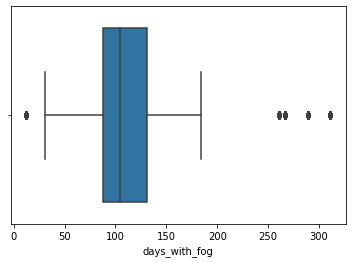

In [40]:
sns.boxplot(df_train['days_with_fog']);

From the plot above, we can see that there are outliers in this features that's why we will use mode to fill in the missing values. We are going to use mode to fill in the missing values in all 6 columns because the contain outliers

In [29]:
#checking out for value counts and mode before filling the missing data
#df_train['days_with_fog'].value_counts()
# df_train['days_with_fog'].mode()[0]

In [39]:
#Filling missing data
df_train['State_Factor'] = df_train['State_Factor'].fillna(df_train['State_Factor'].mode()[0])
df_train['year_built'] = df_train['year_built'].fillna(df_train['year_built'].mode()[0])
df_train['energy_star_rating'] = df_train['energy_star_rating'].fillna(df_train['energy_star_rating'].mode()[0])
df_train['direction_max_wind_speed'] = df_train['direction_max_wind_speed'].fillna(df_train['direction_max_wind_speed'].mode()[0])
df_train['direction_peak_wind_speed'] = df_train['direction_peak_wind_speed'].fillna(df_train['direction_peak_wind_speed'].mode()[0])
df_train['max_wind_speed'] = df_train['max_wind_speed'].fillna(df_train['max_wind_speed'].mode()[0])

In [41]:
df_train['days_with_fog'] = df_train['days_with_fog'].fillna(df_train['days_with_fog'].mode()[0])

In [42]:
df_train.shape[0], df_train.shape[1]

(2727252, 31)

# EDA and Data Pre-processing on the Test Dataset
We are going to replacate what we did on the training data in the test dataset

In [44]:
test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [45]:
test.shape

(9705, 63)

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [47]:
df_test = pd.melt(test, 
            id_vars =['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION','cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog', 'id'])

In [48]:
test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [49]:
variable_split = df_test['variable'].str.split('_', n =1)

In [50]:
variable_split[0]

['january', 'min_temp']

In [51]:
df_test['Months'] = variable_split.str.get(0)
df_test['Unit_Status'] = variable_split.str.get(1)

In [52]:
df_test.drop(['variable'], axis = 1, inplace = True)

In [53]:
df_test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id,value,Months,Unit_Status
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757,38.0,january,min_temp
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758,38.0,january,min_temp
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759,38.0,january,min_temp
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760,38.0,january,min_temp
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761,38.0,january,min_temp


In [54]:
# we will use map to encode State_Factor
df_test['State_Factor'] = df_test['State_Factor'].map({'State_6':1,'State_11':2,'State_1':3,'State_2':4,'State_8':5,
                                                        'State_8':6,'State_10':7})

In [55]:
df_test['building_class'] = df_test['building_class'].map({'Residential':1, 'Commercial':2})

In [56]:
df_test['Months'] = df_test['Months'].map({'january':1,'february':2, 'march':3,'april':4,'may':5,'june':6,'july':7,
                                            'august':8,'september':9,'october':10,'november':11,'december':12})

In [57]:
df_test['Unit_Status'] = df_test['Unit_Status'].map({'min_temp':1,'avg_temp':2,'max_temp':3})

### Filling Missing Data on the Test Dataset

In [58]:
#Filling missing data
df_test['State_Factor'] = df_test['State_Factor'].fillna(df_test['State_Factor'].mode()[0])
df_test['year_built'] = df_test['year_built'].fillna(df_test['year_built'].mode()[0])
df_test['energy_star_rating'] = df_test['energy_star_rating'].fillna(df_test['energy_star_rating'].mode()[0])
df_test['direction_max_wind_speed'] = df_test['direction_max_wind_speed'].fillna(df_test['direction_max_wind_speed'].mode()[0])
df_test['direction_peak_wind_speed'] = df_test['direction_peak_wind_speed'].fillna(df_test['direction_peak_wind_speed'].mode()[0])
df_test['max_wind_speed'] = df_test['max_wind_speed'].fillna(df_test['max_wind_speed'].mode()[0])
df_test['days_with_fog'] = df_test['days_with_fog'].fillna(df_test['days_with_fog'].mode()[0])

### Drop some columns not wanted

In [59]:
#drop columns we won't be using
df_train.drop(['State_Factor','id'], axis = 1, inplace = True)

In [60]:
#drop columns we won't be using
df_test.drop(['State_Factor', 'id'], axis = 1, inplace = True)

In [61]:
# let check the correlations of the features in our data
correlation = df_train.corr()

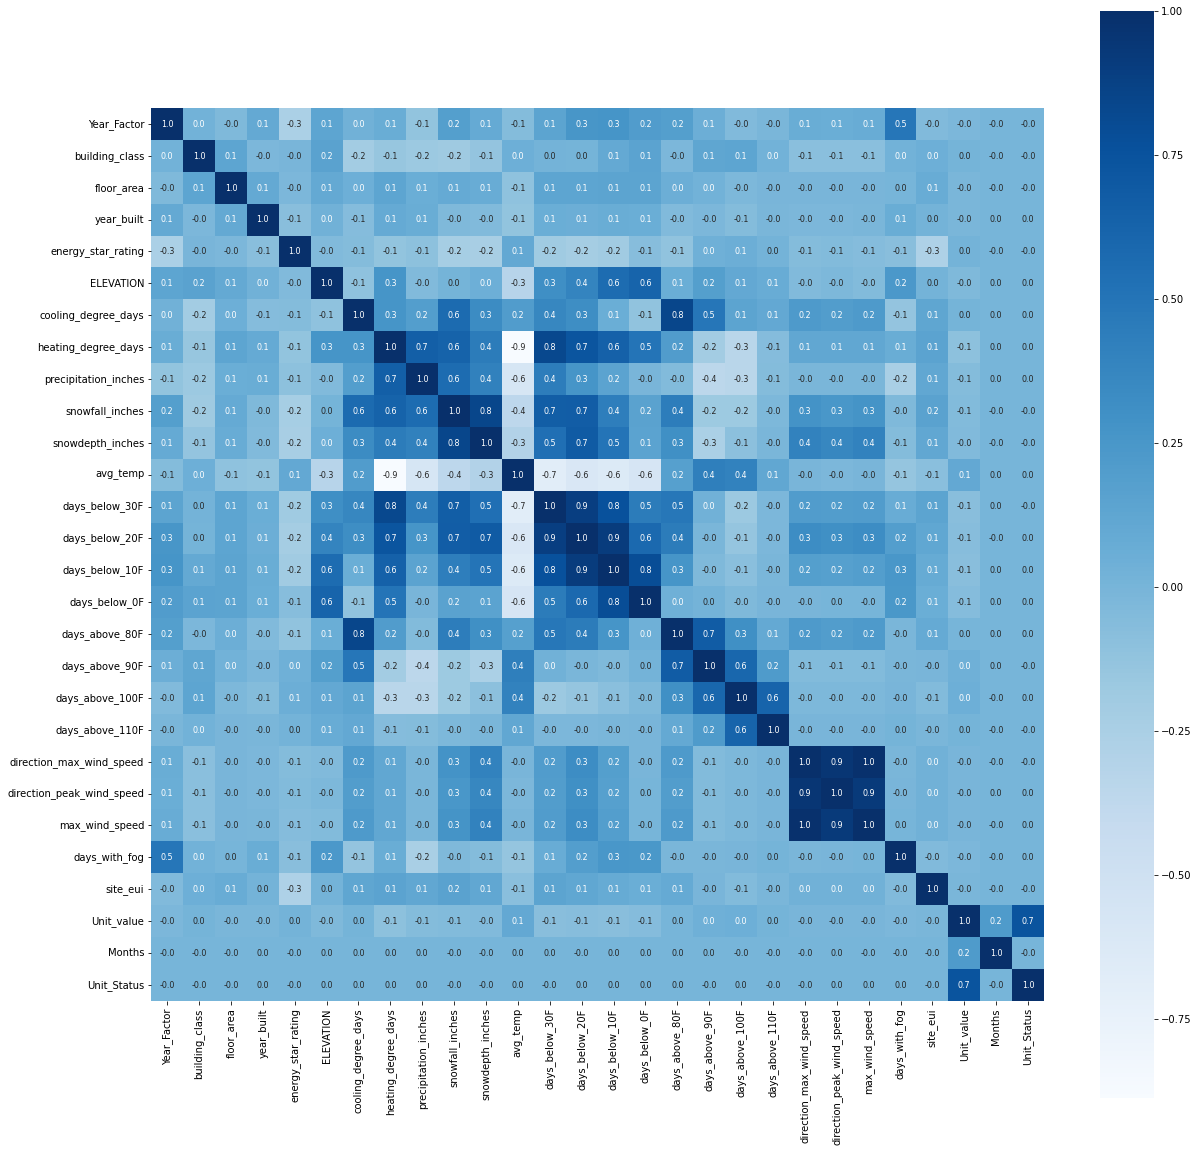

In [62]:
#constructing a heat  to understand the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, cbar=True,square = True, fmt = '.1f', annot = True, annot_kws={'size':8}, cmap='Blues');

In [63]:
# let check the rows and columns of our dataset(train and test) after dropping the cloumns we are not using
print(f'The Row and Column of the train dataset are respectively {df_train.shape[0]} and {df_train.shape[1]}')
print(f'The Row and Column of the test dataset are respectively {df_test.shape[0]} and {df_test.shape[1]}')

The Row and Column of the train dataset are respectively 2727252 and 29
The Row and Column of the test dataset are respectively 349380 and 28


## Encode Categorical features
We will be using one hot encoder to encode facility_type column

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

le = LabelEncoder()
train_encoded = le.fit_transform(df_train['facility_type']) # For integer encoding
test_encoded = le.fit_transform(df_test['facility_type'])
# print(train_encoded)
# print(test_encoded)

OH = OneHotEncoder(sparse= False) # For Binary encoding
train_encoded = train_encoded.reshape(len(train_encoded), 1)
test_encoded = test_encoded.reshape(len(test_encoded), 1)

OH_train = OH.fit_transform(train_encoded)
OH_test = OH.fit_transform(test_encoded)
df_train['facility_type'] = OH_train
df_test['facility_type'] = OH_test

In [66]:
# save a copy of our data
df_train1 = df_train.copy()
df_test1 = df_test.copy()

In [67]:
#drop site_eui on X and y
X = df_train.drop(['site_eui'], axis = 1)
y = df_train1['site_eui']

# Split the data in train_test_split

Let's split our data into test, train and split

In [68]:
X.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,Unit_value,Months,Unit_Status
0,1,2,0.0,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,131.0,36.0,1,1
1,1,2,0.0,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,36.0,1,1
2,1,2,0.0,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,36.0,1,1
3,1,2,0.0,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,12.0,36.0,1,1
4,1,2,0.0,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,131.0,36.0,1,1


In [69]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [70]:
#train_test_split
X_train,X_test, Y_train,Y_test = train_test_split(X, y,test_size = 0.2, random_state=30)
# from sklearn.model_selection import cross_val_score

In [71]:
#check the shape oor data
print(X.shape, X_train.shape, X_test.shape)

(2727252, 28) (2181801, 28) (545451, 28)


In [72]:
#let's check for the std of X_train and X_test
print(X_train.std())

Year_Factor                       1.471276
building_class                    0.494367
facility_type                     0.156075
floor_area                   247546.618585
year_built                       36.969479
energy_star_rating               29.629535
ELEVATION                        60.914673
cooling_degree_days             391.421651
heating_degree_days             824.553847
precipitation_inches             10.591643
snowfall_inches                  17.814801
snowdepth_inches                175.315471
avg_temp                          2.242436
days_below_30F                   27.587633
days_below_20F                   14.472663
days_below_10F                    7.073549
days_below_0F                     2.897339
days_above_80F                   25.278539
days_above_90F                   10.951919
days_above_100F                   2.243774
days_above_110F                   0.140971
direction_max_wind_speed         94.539354
direction_peak_wind_speed        92.465409
max_wind_sp

In [74]:
print(X_test.std())

Year_Factor                       1.472059
building_class                    0.494271
facility_type                     0.156140
floor_area                   244164.969015
year_built                       36.153836
energy_star_rating               29.658348
ELEVATION                        59.610956
cooling_degree_days             392.109593
heating_degree_days             823.591875
precipitation_inches             10.594121
snowfall_inches                  17.794684
snowdepth_inches                175.111372
avg_temp                          2.239881
days_below_30F                   27.584226
days_below_20F                   14.456043
days_below_10F                    7.061666
days_below_0F                     2.881738
days_above_80F                   25.299609
days_above_90F                   10.911907
days_above_100F                   2.286133
days_above_110F                   0.146717
direction_max_wind_speed         94.572501
direction_peak_wind_speed        92.533136
max_wind_sp

In [79]:
# Data Standardization
scaler = StandardScaler()

In [80]:
scaler.fit(X_train)

StandardScaler()

In [81]:
sc_train = scaler.transform(X_train)

In [82]:
sc_train

array([[-2.49926030e-01, -8.60003179e-01, -1.60073910e-01, ...,
        -3.38846850e-01, -4.34898469e-01, -1.22495554e+00],
       [-2.49926030e-01,  1.16278640e+00, -1.60073910e-01, ...,
         4.60947108e-01,  1.59277922e+00,  1.22454351e+00],
       [ 1.10943893e+00, -8.60003179e-01, -1.60073910e-01, ...,
        -2.78032314e+00,  1.59277922e+00, -1.22495554e+00],
       ...,
       [-2.49926030e-01, -8.60003179e-01, -1.60073910e-01, ...,
        -8.16143245e-01, -1.01423495e+00, -2.06014699e-04],
       [-9.29608510e-01, -8.60003179e-01, -1.60073910e-01, ...,
        -7.17696620e-01,  1.01344274e+00, -1.22495554e+00],
       [-9.29608510e-01,  1.16278640e+00, -1.60073910e-01, ...,
        -1.60167942e+00,  1.59277922e+00, -1.22495554e+00]])

In [83]:
#standardize X_test
sc_test = scaler.transform(X_test)

In [84]:
#let's check we have succesfully standardized our data
print(sc_train.std())

0.9999999999999991


In [85]:
print(sc_test.std())

0.9996545854402202


In [86]:
# !pip install xgboost

## Modelling

In [87]:
# from sklearn.ensemble import GradientBoostingRegressor
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.42,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [88]:
model.fit(sc_train, Y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.42, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation

In [89]:
#predict on training dataset
pred_train = model.predict(sc_train)

In [90]:
pred_test = model.predict(X_test)

In [91]:
print(pred_test)

[69.184166 63.697174 71.9358   ... 62.444927 63.697174 69.184166]


In [92]:
# ypred = xgbr.predict(xtest)
# mse = mean_squared_error(ytest, ypred)

# Mean Absolute error
RMSE = np.sqrt(mean_squared_error(Y_test, pred_test)) #it finds the difference btw the two values

In [93]:
print(f'for test data : {RMSE}')

for test data : 62.328933380753455


In [94]:
RMSE_train = np.sqrt(mean_squared_error(Y_train, pred_train)) #it finds the difference btw the two values

In [95]:
print(f'For train data :{RMSE_train}')

For train data :51.22623959172068


In [96]:
sample_sub = pd.read_csv('sample_solution.csv')

In [97]:
sample_sub.head()

,id,site_eui
0,75757,0.0
1,75758,0.0
2,75759,0.0
3,75760,0.0
4,75761,0.0


In [98]:
sample_sub['site_eui'] = RMSE

In [99]:
sample_sub.head()

,id,site_eui
0,75757,62.328933
1,75758,62.328933
2,75759,62.328933
3,75760,62.328933
4,75761,62.328933


C:\Users\oriji sandra\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='site_eui', ylabel='count'>

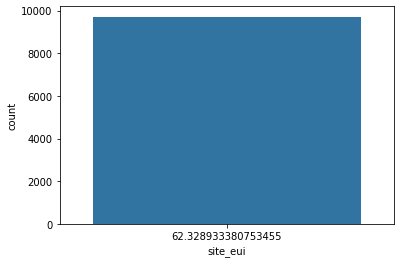

In [100]:
sns.countplot(sample_sub['site_eui'])

In [101]:
sample_sub.to_csv('my_third_sub', index = False)